# K-mean clustering
This Matlab code has been completed as part of [Machine Learning](https://www.coursera.org/learn/machine-learning)
course in Coursera given by Prof. Andrew Ng

------------
This note demonstrates the use of principal component analysis (PCA) to find a low-dimensional representation of the data. The example taken in this note is face images.

This notebook includes:

- <a href='#part1'>Part 1: Find Closest Centroids</a>
- <a href='#part2'>Part 2:  Image compression with K-means</a>

This code requires the following functions
* <a href='https://github.com/linhvannguyen/MachineLearning_AndrewNG/blob/master/matlab/funcs/funcs_09_KmeanPCA_drawLine.m'>funcs_09_KmeanPCA_drawLine.m</a>

In [1]:
clear all; close all; clc; warning off;
addpath('../data/') % add path to directory containing data files
addpath('./funcs/') % add path to directory containing subfunction files

## Part 1: Implement K-mean algorithm <a id='part1'></a>
The K-means algorithm is a method to automatically cluster similar data examples together. Given a training set $\left \{ x^{(1)} , ..., x^{(m)} \right \}$, $x^{(i)} \in R^n, K-mean clustering algorithm groups the data into a few cohesive "clusters". The intuition behind K-means is an iterative procedure that starts by guessing the initial centroids, and then refines this guess by repeatedly assigning examples to their closest centroids and then recomputing the centroids based on the assignments. The algorithm should be somthing like:


In [2]:
%{

% Initialize centroids
centroids = initCentroids

loop until convergence
    % Cluster assignment step: Assign each data point to the closest centroid
    idx = findClosestCentroids(X, centroids);

    % Move centroid step: Compute means based on centroid assignments
    centroids = computeMeans(X, idx, K);

%}

The inner-loop of the algorithm repeatedly carries out two steps: 
* Step 1: Assigning each training example $x^{(i)}$ to its closest centroid
* Step 2: Recomputing the mean of each centroid using the points assigned to it. 

The K-means algorithm will always converge to some final set of means for the centroids. Note that the converged solution may not always be ideal and depends on the initial setting of the centroids. Therefore, in practice the K-means algorithm is usually run a few times with different random initializations. One way to choose between these different solutions from different random initializations is to choose the one with the lowest cost function value (distortion).

Centroids can take specific values, or be generated automatically to be random examples. In practice, a good strategy for initializing the centroids is to select random examples from the training set.

#### Step 1: Find closest centroids 
In the "cluster assignment" phase of the K-means algorithm, the algorithm assigns every training example $x^{(i)}$ to its closest centroid, given the current positions of centroids. Specifically, for every example i we set 

$$ c^{(i)}:=j \:\: that \:\: minimizes \:\: \left\lVert x^{(i)}-\mu_j\right\rVert^2$$

where $c^{(i)}$ is the index of the centroid that is closest to $x^{(i)}$ , and $\mu_j$ is the position (value) of the j'th centroid.

#### Step 2: Computing centroid means
Given assignments of every point to a centroid, the second phase of the algorithm recomputes, for each centroid, the mean of the points that were assigned to it. For every centroid k:

$$\mu_k:=\frac{1}{|C_k| \sum_{i \in C_k}{x^{(i)}}}$$

where $C_k$ is the set of examples that are assigned to centroid k.

#### Example: 2D dataset

We will run the K-means algorithm on a toy 2D dataset

In [3]:
load('data_09_Kmean_data2.mat');
[m,n] = size(X);

K = 3;
max_iters = 10;

% Randomly reorder the indices of examples
randidx = randperm(size(X, 1));

% Take the first K examples as centroids
initial_centroids = X(randidx(1:K), :);
centroids = initial_centroids;

% Run K-Means
for i=1:max_iters    
    % Step 1: For each example in X, assign it to the closest centroid
    dist_all=zeros(m,K); % distant of all samples to K centroids
    for i=1:K
        temp=X-repmat(centroids(i,:),m,1);
        temp=temp.^2;
        dist_all(:,i)=sum(temp,2); 
    end

    [~,idx]=min(dist_all,[],2);
    
    
    % Step 2: Given the memberships, compute new centroids
    centroids = zeros(K, size(X,2));

    for j=1:K
        Xk=X(idx==j,:);
        centroids(j,:)=mean(Xk,1);
    end
end

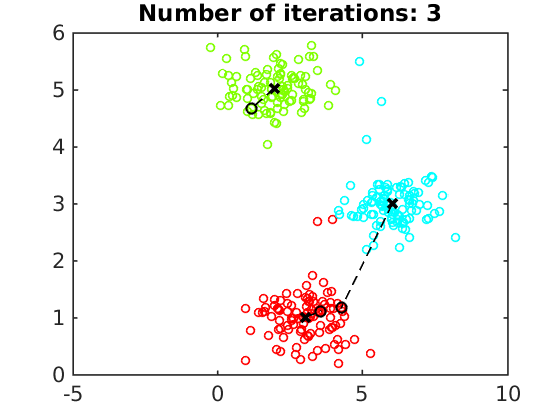

In [4]:
figure;
hold on;

% Create palette
palette = hsv(K + 1);
colors = palette(idx, :);

% Plot the data
scatter(X(:,1), X(:,2), 15, colors);

% Plot the centroids
plot(centroids(:,1), centroids(:,2), 'x', 'MarkerEdgeColor','k', 'MarkerSize', 5, 'LineWidth', 2);

% Plot the initial centroids
plot(initial_centroids(:,1), initial_centroids(:,2), 'o', 'MarkerEdgeColor','k', 'MarkerSize', 5, 'LineWidth', 1);
for j=1:size(centroids,1)
    funcs_09_KmeanPCA_drawLine(centroids(j, :), initial_centroids(j, :),'k--');
end

title(sprintf('Number of iterations: %d', i))
hold off
box on

## Part 2: Image compression with K-means <a id='part2'></a>

This part applies K-means to image compression. In a straightforward 24-bit color representation of an image, 2 each pixel is represented as three 8-bit unsigned integers (ranging from 0 to 255) that specify the red, green and blue intensity values. This encoding is often refered to as the RGB encoding. Our image contains thousands of colors, and in this part of the exercise, you will reduce the number of colors to 16 colors.

By making this reduction, it is possible to represent (compress) the photo in an efficient way. Specifically, you only need to store the RGB values of the 16 selected colors, and for each pixel in the image you now need to only
store the index of the color at that location (where only 4 bits are necessary to represent 16 possibilities).
In this exercise, you will use the K-means algorithm to select the 16 colors that will be used to represent the compressed image. Concretely, you will treat every pixel in the original image as a data example and use the K-means algorithm to find the 16 colors that best group (cluster) the pixels in the 3-dimensional RGB space. Once you have computed the cluster centroids on the image, you will then use the 16 colors to replace the pixels in the original image.

In [5]:
%  Load an image of a bird and rescale values to the range [0,1]
A = double(imread('data_09_Kmean_bird_small.png'));
A = A / 255; 
img_size = size(A);

% Reshape the image into an Nx3 matrix where N = number of pixels.
% Each row will contain the Red, Green and Blue pixel values
% This gives us our dataset matrix X that we will use K-Means on.
X = reshape(A, img_size(1) * img_size(2), 3);
[m,n] = size(X);

% Run your K-Means algorithm on this data
K = 16; 
max_iters = 10;

% Initialize the centroids randomly. 
randidx = randperm(size(X, 1));
initial_centroids = X(randidx(1:K), :);

centroids = initial_centroids;

% Run K-Means
for i=1:max_iters    
    % For each example in X, assign it to the closest centroid
    dist_all=zeros(m,K); % distant of all samples to K centroids
    for i=1:K
        temp=X-repmat(centroids(i,:),m,1);
        temp=temp.^2;
        dist_all(:,i)=sum(temp,2); 
    end
    [~,idx]=min(dist_all,[],2);
     
    % Given the memberships, compute new centroids
    centroids = zeros(K, size(X,2));
    for j=1:K
        Xk=X(idx==j,:);
        centroids(j,:)=mean(Xk,1);
    end
end

### Image Compression 

The image is reshaped to form an m × 3 matrix of pixel colors (where m = 16384 = 128 × 128), and K-means is applied on it. After finding the top K = 16 colors to represent the image, we assign each pixel position to its closest centroid. This allows you to represent the original image using the centroid assignments of each pixel. Notice that you have significantly reduced the number of bits that are required to describe the image. The original image
required 24 bits for each one of the 128×128 pixel locations, resulting in totalsize of 128 × 128 × 24 = 393, 216 bits. The new representation requires some overhead storage in form of a dictionary of 16 colors, each of which require 24 bits, but the image itself then only requires 4 bits per pixel location. The final number of bits used is therefore 16 × 24 + 128 × 128 × 4 = 65, 920 bits, which corresponds to compressing the original image by about a factor of 6.

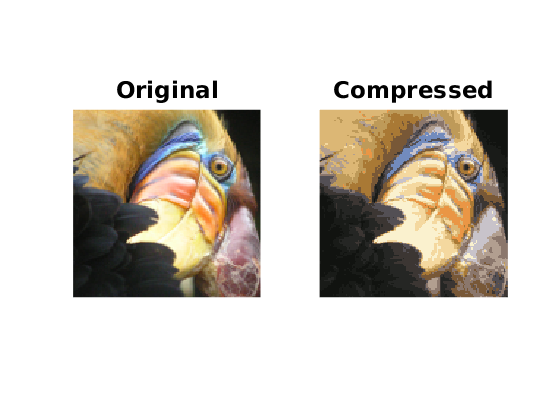

In [6]:
% Find closest cluster members
dist_all=zeros(size(X,1),K); % distant of all samples to K centroids
for i=1:K
    temp=X-repmat(centroids(i,:),size(X,1),1);
    temp=temp.^2;
    dist_all(:,i)=sum(temp,2); 
end

% Represent the image X in terms of the indices in idx. 
[~,idx]=min(dist_all,[],2);
    
% We can now recover the image from the indices (idx) by mapping each pixel
% (specified by it's index in idx) to the centroid value
X_recovered = centroids(idx,:);

% Reshape the recovered image into proper dimensions
X_recovered = reshape(X_recovered, img_size(1), img_size(2), 3);

% Display the original image 
figure();
subplot(1, 2, 1);
imagesc(A); axis equal; axis off; axis tight;
title('Original');

% Display compressed image side by side
subplot(1, 2, 2);
imagesc(X_recovered);axis equal; axis off; axis tight;
title('Compressed');